In [10]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import torchvision.transforms as transforms
from torchvision.io import read_image
import numpy as np
from numpy import random
import pandas as pd
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import splitext
from glob import glob
from PIL import Image
from tqdm import tqdm
import logging
from unet_model import UNet

In [18]:
class TheDataset(Dataset):
    def __init__(self, interlaced_dir, gtruth_dir, scale=1):
        self.interlaced_dir = interlaced_dir
        self.gtruth_dir = gtruth_dir
        self.scale = scale
        self.transform = transforms.Compose([transforms.RandomCrop(256), transforms.ToTensor()])
        
        assert 0 < scale <= 1, 'Scale must be between 0 and 1'

        self.ids = [splitext(file)[0] for file in listdir(interlaced_dir)]
        logging.info(f'Creating dataset with {len(self.ids)} examples')

    def __len__(self):
        return len(self.ids)

    @classmethod
    def preprocess(cls, pil_img, scale):
        #pil_img = pil_img / 255.0
        
        return pil_img

    def __getitem__(self, i):
        idx = self.ids[i]
        gtruth_file = glob(self.gtruth_dir + idx + '.*')
        interlaced_file = glob(self.interlaced_dir + idx + '.*')

        assert len(gtruth_file) == 1, \
            f'Either no mask or multiple masks found for the ID {idx}: {gtruth_file}'
        assert len(interlaced_file) == 1, \
            f'Either no image or multiple images found for the ID {idx}: {interlaced_file}'
        gtruth = Image.open(gtruth_file[0])
        interlaced = Image.open(interlaced_file[0])

        assert interlaced.size == gtruth.size, \
            f'Image and mask {idx} should be the same size, but are {interlaced.size} and {gtruth.size}'
        
        seed = np.random.randint(2147483647) # make a seed with numpy generator 
        
        random.seed(seed) # apply this seed to img tranfsorms
        torch.manual_seed(seed) # needed for torchvision 0.7
        interlaced = self.transform(interlaced)
        interlaced = self.preprocess(interlaced, self.scale)
        
        random.seed(seed) # apply this seed to img tranfsorms
        torch.manual_seed(seed) # needed for torchvision 0.7
        gtruth = self.transform(gtruth)
        gtruth = self.preprocess(gtruth, self.scale)

        return interlaced, gtruth
    

In [19]:
interlaced_dir = "./dataset/interlaced/1/"
gtruth_dir = "./dataset/ground_truth/1/"
img_scale = 1

In [20]:
def train_net(net,
              device,
              epochs=5,
              batch_size=1,
              lr=0.001,
              val_percent=0.1,
              save_cp=True,
              img_scale=1):

    dataset = TheDataset(interlaced_dir, gtruth_dir, img_scale)
    n_val = int(len(dataset) * val_percent)
    n_train = len(dataset) - n_val
    train, val = random_split(dataset, [n_train, n_val])
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, pin_memory=True, drop_last=True)
    for inter, truth in tqdm(train_loader):
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(inter[0].permute(1,2,0))
        axarr[1].imshow(truth[0].permute(1,2,0))
        break


  0%|                                                                                                                        | 0/16986 [00:01<?, ?it/s]


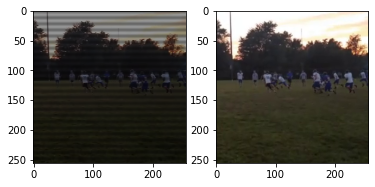

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = UNet(n_channels=3, bilinear=True)
train_net(net=net,
          epochs=10,
          batch_size=5,
          lr=0.01,
          device=device,
          img_scale=1,
          val_percent=0.1)